# PyTorchでMLP



## ライブラリのinstall


jupyterでは!をつけるとshのコマンドが実行できます。


In [2]:
!pip install -q http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

    100% |████████████████████████████████| 61kB 3.8MB/s 
    100% |████████████████████████████████| 2.0MB 10.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## ライブラリのimport

必要なライブラリをimportします。

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
% matplotlib inline

## ハイパーパラメータの設定

In [0]:
# Hyper Parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

## データを取得

datasets.MNISTでMNISTをダウンロード


In [5]:
# MNIST Dataset 
train_dataset = datasets.MNIST(root='../data', 
                            train=True, 
                            transform=transforms.ToTensor(),  
                            download=True)

test_dataset = datasets.MNIST(root='../data', 
                              train=False, 
                              transform=transforms.ToTensor())

Processing...
Done!


ここでダウンロードしたMNISTの中身は以下のような手書きの数字データ

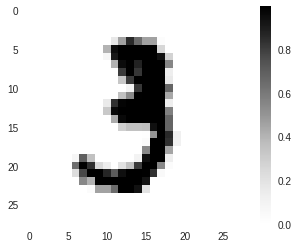

In [55]:
plt.figure()
plt.imshow(train_dataset[10][0][0].numpy())
plt.colorbar()
plt.gca().grid(False)

データを学習用にminibatch単位で切り出す準備

In [0]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


## 三層のニューラルネットワークのクラスを定義


In [0]:
# Neural Network Model (1 hidden layer)
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## ニューラルネットワークのクラスからインスタンスを作成。

.cudaメソッドでCUDAで動くように変換

In [8]:
net = Net(input_size, hidden_size, num_classes)
net.cuda()

Net(
  (fc1): Linear(in_features=784, out_features=500)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10)
)

## 損失関数・オプティマイザの設定

ここでは

- 損失関数: クロスエントロピー
- オプティマイザ: Adam

を使います。


In [0]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  


## トレーニング関数

num_epochs回学習を繰り返す関数を作ります。

netインスタンスに入れるデータも.cudaでGPUで動くように変換することを忘れないでください。



In [0]:
def fit(net, train_loader, num_epochs=num_epochs, t= 200):
  # モデルのトレーニング
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):  
          # pytorchのtensorをVariableに変換
          images = Variable(images.view(-1, 28*28)).cuda()
          labels = Variable(labels).cuda()

          # フォワードプロパゲーション/ バックプロパゲーション/ 最適化
          optimizer.zero_grad()  # 勾配を0初期化
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          
          # t回毎にログを表示
          if (i+1) % t == 0:
              print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                     %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
  return net

In [36]:
net = fit(net, train_loader)

Epoch [1/5], Step [200/600], Loss: 0.0068
Epoch [1/5], Step [400/600], Loss: 0.0024
Epoch [1/5], Step [600/600], Loss: 0.0028
Epoch [2/5], Step [200/600], Loss: 0.0010
Epoch [2/5], Step [400/600], Loss: 0.0770
Epoch [2/5], Step [600/600], Loss: 0.0013
Epoch [3/5], Step [200/600], Loss: 0.0011
Epoch [3/5], Step [400/600], Loss: 0.0017
Epoch [3/5], Step [600/600], Loss: 0.0007
Epoch [4/5], Step [200/600], Loss: 0.0001
Epoch [4/5], Step [400/600], Loss: 0.0003
Epoch [4/5], Step [600/600], Loss: 0.0074
Epoch [5/5], Step [200/600], Loss: 0.0057
Epoch [5/5], Step [400/600], Loss: 0.0028
Epoch [5/5], Step [600/600], Loss: 0.0036


## テスト関数

テストデータを使ったモデルの評価を行う関数を作ります。



In [0]:
def evaluate(net, test_loader=test_loader):
  # Test the Model
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = Variable(images.view(-1, 28*28)).cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted.cpu() == labels).sum()

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


In [34]:
evaluate(net)

Accuracy of the network on the 10000 test images: 98 %
